In [2]:
# Analysis
import os
import glob
import numpy as np
import pandas as pd
import scipy

# Plotting
import PIL
from PIL import ImageDraw, Image
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

# Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

<a id='saliency'></a>
>### Saliency Map

Saliency maps is similar to [CAM](#cam), with some differences: 
- Show the relevant pixels instead of the learned features.
- Generate saliency maps by getting the gradient of the loss with respect to the pixels.
- Large gradients means the model is learning from those pixels with loss decreased, and will be shown brightly in saliency map.

In [5]:
import tensorflow_hub as hub
import cv2

#### Data

In [247]:
def preprocess_cv2(image, height, width):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image = cv2.resize(image, (height, width)) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

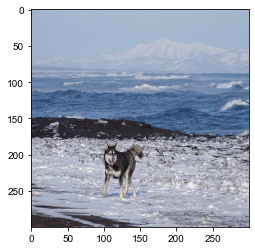

In [194]:
image_path = 'images/husky.jpg'
image = cv2.imread(image_path) #因为最后用cv2画图，不知道为啥只有用cv2打开图后续才不会报错
image = preprocess_cv2(image, 300, 300)
plt.imshow(image[0])

In [195]:
# class ID in ImageNet (0 bg, 1-1000 class)
class_index = 251 #Siberian husky (251), Tabby cat (282)
n_classes = 1001
y_true = tf.one_hot([class_index], n_classes) #(1,1001)
y_true

<tf.Tensor: shape=(1, 1001), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

#### Model
[Inception V3 model](https://arxiv.org/abs/1512.00567) with pre-trained weights is able to detect 1001 classes.

In [196]:
MODEL_TYPE = "inception_v3" 
MODULE_HANDLE = f"https://tfhub.dev/google/tf2-preview/{MODEL_TYPE}/classification/4"
INPUT_SHAPE = (300,300,3)

In [168]:
model = keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, input_shape=INPUT_SHAPE), 
    layers.Activation('softmax') #加这层是为了输出one-hot
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1001)              23853833  
_________________________________________________________________
activation_4 (Activation)    (None, 1001)              0         
Total params: 23,853,833
Trainable params: 0
Non-trainable params: 23,853,833
_________________________________________________________________


#### Gradients

In [197]:
#求预测loss对图片每个pixel的gradients
image_tensor = tf.cast(image, tf.float32)
with tf.GradientTape() as tape:
    tape.watch(image_tensor)
    y_pred = model(image_tensor) #得到y tensor，方便下面求loss，model.predict得到numpy
    loss = keras.losses.categorical_crossentropy(y_true, y_pred)

gradients = tape.gradient(loss, image_tensor)
gradients.shape

TensorShape([1, 300, 300, 3])

In [206]:
def preprocess_grad(gradients):
    gradients = tf.abs(gradients) #找绝对值最大的gradients
    gradients = tf.reduce_sum(gradients, axis=-1) #RGB gradients相加(1,300,300,3)->(1,300,300)
    gradients = tf.squeeze(gradients) #(1,300,300)->(300,300)
    gradients = (gradients - tf.reduce_min(gradients))/(tf.reduce_max(gradients)-tf.reduce_min(gradients)) #(x-min)/(max-min), [0,1]
    gradients = gradients*255 #[0,255]
    gradients = tf.cast(gradients, tf.uint8)
    return gradients

def tensor_to_image(tensor, path):
    tensor = tf.expand_dims(tensor, -1) #确保是(w,h,c)
    tensor = tf.io.encode_jpeg(tensor, quality=100, format='grayscale') #默认95quality，rgb
    tf.io.write_file(path, tensor)
    print(f'Tensor saved to {path}')

def image_to_tensor(path):
    image = tf.io.read_file(path) #从路径读取图片
    image = tf.image.decode_jpeg(image) #从jpeg转成tensor
    return image

In [199]:
gradients = preprocess_grad(gradients)
gradients.shape

TensorShape([300, 300])

In [200]:
# saliency显示class在学习哪些pixel
def plot_saliency(image, gradients):
    plt.figure(figsize=(15,10))
    #原图
    plt.subplot(1,3,1)
    plt.imshow(image[0]) #[0,1]
    #gradients
    plt.subplot(1,3,2)
    plt.imshow(gradients, cmap='gray') #[0,255]
    #混合
    plt.subplot(1,3,3)
    gradients_RGB = cv2.applyColorMap(gradients.numpy(), cv2.COLORMAP_HOT) #利用cv2给分配颜色
    gradients_RGB = gradients_RGB / 255.0 #[0-1] 混合时保持数字格式一致
    combined = cv2.addWeighted(src1=image[0], alpha=0.5, #第一张图，及其比重
                               src2=gradients_RGB, beta=0.5, #第二张图，及其比重
                               gamma=0.0) #额外加的值
    plt.imshow(combined)
    plt.axis('off')

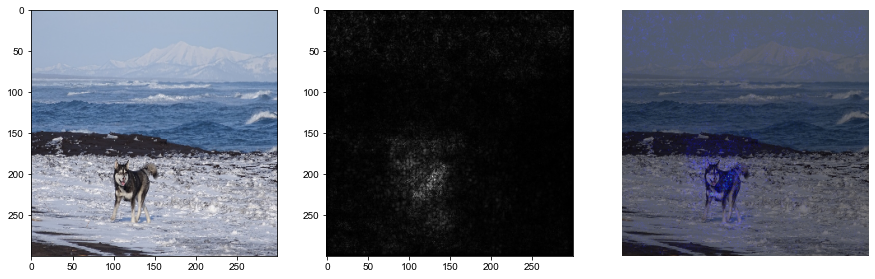

In [201]:
plot_saliency(image, gradients)